<h1>Genshin Impact Voice Line Sentiment Analysis</h1>

Genshin Impact is an open world action RPG (Role Playing Game) developed by Hoyoverse. It was released on September 28, 2020 and gets regular updates about every two months. One of the game's main components is the combat system. Players can fight enemies in the game with different characters they meet in the main story. Along with having certain fighting skills, they also have their own backstories and personalities. While you are given a few characters at the start of the game, in order to get more, you need to "wish" for those characters, which means spending in game currency for a chance to obtain them. If you do get the character, along with being able to use them in combat, you also gain access to their voice lines, which help give more insight into their personalities. 

Each character has specific traits, like the element they wield (called a vision), the region they're from, the type of weapon they use, etc. This tutorial will attempt to see if there is correlation between any of these traits and how positive the character's demeanor is using their voice lines.

<h2>Data collection/curation + parsing</h2>

The data we need to collect is the voice lines for each character, along with aspects like gender, weapon type, vision etc. There is actually a <a href="https://www.kaggle.com/datasets/sophiahealy/genshin-impact-character-data">dataset on Kaggle</a> with everything needed except for the voice lines, so I can easily use that. I do need to clean it up and narrow it down, since the dataset has quite a bit of information I don't need. The initial dataset had 70 columns of information on each character, but I've narrowed it down to less than 10. I only chose aspects I thought would be relavent, like gender, vision type, and weapon type and dropped things like favorite food or birthday since they won't be useful for my analysis. I also had to narrow what character data I wanted. Only playable characters have voice lines, so I needed to get rid of all characters that weren't in my dataset. I also got rid of Traveler, the player's POV character, since they were a bit of an outlier, considering they could be either a boy or girl, could wield multiple elements and it would simply muddle my analysis. 

I want to have gender as a column, but the original dataset only has model. Since the model incudes gender, I use that to create a new column for gender. I choose to have a column with 0 representing female characters and 1 representing male characters. I use integers to represent this for later anaytical use.


In [1]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from IPython.display import HTML
import html5lib
import re

In [2]:
#Getting genshin character data from other dataset
char_stat = pd.read_csv("~/Desktop/CMSC320/final.resources/genshin.csv")

#Dropping all non-playable characters (since they don't have voice lines)
char_stat = char_stat[char_stat['playable'].str.contains('Y') == True]

#Dropping Traveler because they would a total outlier
#They can be either a boy or girl,and have different HP, ATK, DEF stats 
#based on which gender they are, and can wield multiple elements
#In general, they would complicate our analysis if included
char_stat = char_stat[char_stat['character_name'].str.contains('Traveler') == False]

#Narrowing down columns to only include relevant data we will use
char_stat = char_stat[['character_name', 'rarity', 'region', 'vision', 'weapon_type', 'model', 'hp_90_90', 'atk_90_90', 'def_90_90']]


gen_lst = []
for i in range(0, 56):
    if 'Male' in char_stat.iloc[i][5]:
        gen_lst.append(1)
    else:
        gen_lst.append(0)
        
char_stat['Gender'] = gen_lst


After narrowing down my data to only include the information I want, I need to clean it. I rename the columns to make them more readable and check for any null entries in the dataset. I found only one instance, for the character Aloy's region. This makes sense, as Aloy is a crossover character from another game and her region is unknown. So I simply swap the null value for the string "Unknown".

In [3]:
#Reseting index properly
char_stat = char_stat.reset_index(drop=True)
#Properly naming columns to make dataframe more readable
char_stat.columns = ['Name','Rarity', 'Region', 'Vision', 'Weapon', 'Model', 'Base HP at level 90/90', 'Base ATK at level 90/90', 'Base DEF at level 90/90', 'Gender']
char_stat[char_stat.isna().any(axis=1)]


,Name,Rarity,Region,Vision,Weapon,Model,Base HP at level 90/90,Base ATK at level 90/90,Base DEF at level 90/90,Gender
1,Aloy,5.0,NaN,Cryo,Bow,Medium Female,10899.0,234.0,676.0,0


In [4]:
char_stat.fillna('Other', inplace=True)
char_stat.head()

,Name,Rarity,Region,Vision,Weapon,Model,Base HP at level 90/90,Base ATK at level 90/90,Base DEF at level 90/90,Gender
0,Albedo,5.0,Mondstadt,Geo,Sword,Medium Male,13226.0,251.0,876.0,1
1,Aloy,5.0,Other,Cryo,Bow,Medium Female,10899.0,234.0,676.0,0
2,Amber,4.0,Mondstadt,Pyro,Bow,Medium Female,9461.0,223.0,601.0,0
3,Arataki Itto,5.0,Inazuma,Geo,Claymore,Tall Male,12858.0,227.0,959.0,1
4,Barbara,4.0,Mondstadt,Hydro,Catalyst,Medium Female,9787.0,159.0,669.0,0


Next, I decide to encode my categorical values. This will make it easier to do correlation calculations later down the line and simplifies the meaning of my data. I manually do this with a dictionary so I can easily keep track of which values represent which categories and make plotting data smoother.

In [5]:
#Creating dictionaries to replace strings in data with integers, which will be useful for 
#analysis in the futute
cleanup = {"Region":     {"Mondstadt": 0, "Liyue": 1, "Inazuma": 2, "Sumeru": 3, "Snezhnaya": 4, "Other": 5},
                "Vision": {"Anemo": 0, "Geo": 1, "Electro": 2, "Dendro": 3,
                                  "Hydro": 4, "Pyro": 5, "Cryo": 6 },
                "Weapon": {"Sword": 0, "Bow": 1, "Claymore": 2, "Catalyst": 3, "Polearm": 4},
               }
#Replacing most categories in data set for integers
char_stat = char_stat.replace(cleanup)
char_stat.head()

,Name,Rarity,Region,Vision,Weapon,Model,Base HP at level 90/90,Base ATK at level 90/90,Base DEF at level 90/90,Gender
0,Albedo,5.0,0,1,0,Medium Male,13226.0,251.0,876.0,1
1,Aloy,5.0,5,6,1,Medium Female,10899.0,234.0,676.0,0
2,Amber,4.0,0,5,1,Medium Female,9461.0,223.0,601.0,0
3,Arataki Itto,5.0,2,1,2,Tall Male,12858.0,227.0,959.0,1
4,Barbara,4.0,0,4,3,Medium Female,9787.0,159.0,669.0,0


I also want to add each character's total revenue (how much money has been spent on a banner of theirs to "wish" for them), and have used <a href=https://www.kaggle.com/datasets/sophiahealy/genshin-impact-character-data>this dataset</a> on Kaggle. The dataset has different entries per banner, and the same character can have multiple banners, so I need to take that into account when calculating the total money made for each character. In addition, the only characters who have banners are 5 star characters, so for all other characters, I'll set their revenue to 0.

In [6]:
#Fetching the table from my downloaded file
revenue = pd.read_csv("~/Desktop/CMSC320/final.resources/archive/char_revenue.csv")

#Iterating through every row of char_stat, for each row, adds revenue for that character
rev_lst = []
for name in char_stat['Name']:
    curr_rev = 0
    #Iterating through revenue, adds all banner revenue of the current character
    for index, row in revenue.iterrows():
        if name in row['5_star_characters']:
            curr_rev+=int(row['revenue'].replace(',', ''))
    rev_lst.append(curr_rev)
#Adding all character revenues to char_stat
char_stat['Revenue'] = rev_lst
char_stat.head()

,Name,Rarity,Region,Vision,Weapon,Model,Base HP at level 90/90,Base ATK at level 90/90,Base DEF at level 90/90,Gender,Revenue
0,Albedo,5.0,0,1,0,Medium Male,13226.0,251.0,876.0,1,44573853
1,Aloy,5.0,5,6,1,Medium Female,10899.0,234.0,676.0,0,0
2,Amber,4.0,0,5,1,Medium Female,9461.0,223.0,601.0,0,0
3,Arataki Itto,5.0,2,1,2,Tall Male,12858.0,227.0,959.0,1,25990836
4,Barbara,4.0,0,4,3,Medium Female,9787.0,159.0,669.0,0,0


The game gets updated quite frequently and often introduces new playable characters, so I want to check if the current data is up to date. I know that the revenue dataset is updated to the latest version of the game, but it's unclear exactly how recent the first Kaggle dataset I used is. I parsed a <a href=https://gamewith.net/genshin-impact/article/show/22357>webpage</a> that had a list of all of the current playable characters as of 12/11/22 and it looks like characters from version 3.2 (which released 11/2/22) and above will be missing from my analysis. While Childe is a character from before that, he also goes by the name Tartaglia and his data is recorded under that name. I consciously excluded Traveler, so I don't have to worry about them either.

In [7]:
#Fetching the table from the page, only using the names column
page_table = pd.read_html('https://gamewith.net/genshin-impact/article/show/22357')[1]
df3 = (pd.DataFrame(data=page_table))
df3 = df3['Character']

#Printing all characters that aren't in the dataset
#I'll simply manually check what version they released in
for n in df3:
    if (char_stat['Name'].str.contains(n).any() == False):
        print(n)

Nahida
Scaramouche
Childe
Dendro Traveler
Faruzan
Layla
Electro Traveler
Geo Traveler
Anemo Traveler


Now, I have to get the voice lines for each character. I know that the <a href=https://genshin-impact.fandom.com/wiki/Genshin_Impact_Wiki>Genshin Wiki</a> has tables of every character's voice lines, so I can just parse through those webpages to get them. To make things simple, I write a function that given the name of a character, will return a dataframe of the voice lines of said character. This way, I can iterate through every character's name in the dataset I made above and then concatenate all of them together to create one dataframe with every character's voice lines.

Most of the cleanup for the creation of this voice line dataset is done inside the function below. The Genshin Wiki has a consistant structure for every character voice line webpage link. They're all identical except for one part where the character's name goes. So I can use this, create a link that follows that same structure and input the given name parameter to fetch the table from that webpage. One thing I did need to account for was characters with multiple word names. But the Genshin Wiki convention to handle that is to use underscores for spaces in the link, so I simply replaced spaces with underscores when fetching the table from the link.

I need to do some additional clean up to the voice lines from the webpages. On the site, the transcript for each line is there along with an audio recording of it as well. When the table of all the lines gets extracted and put into a dataframe, there's a series of letters and numbers representing the audio file that get attached to the voice lines themselves. This unwanted string always ends with a .ogg (likely representing the file type), so I simply using a regular expression to split the original string into the actual voice line and unwanted text and replace the voice lines in the table with the strings that only comprised of the voice line itself. I also got rid of all null values in the table (when looking through them, they were simply repeats of existing voice lines) and renamed the columns to make the final table more readable.

In [8]:
def charv_df(name):
    
    link = 'https://genshin-impact.fandom.com/wiki/' + name + '/Voice-Overs'
    #Accounts for characters that have more than one word names
    link = link.replace(" ", "_")

    #Getting the table from the webpage and creating a dataframe from it
    page = requests.get(link)
    page_text = page.text
    page_soup = BeautifulSoup(page.content, 'html.parser')
    page_var = page_soup.find_all('tr')
    page_table = pd.read_html(link)[2]
    df = (pd.DataFrame(data=page_table))

    #Getting rid of NaN values in table (they were only repeats of existing voicelines)
    df = df.dropna()

    #Resetting index so I can properly work with it
    df = df.reset_index(drop=True)
    
    #Creating a name list to later add as a column to the dataframe
    #(will be useful when doing sentiment anaylsis for each character later)
    name_lst = []

    #Going through all voicelines in dataframe, gets rid of unecessary text
    #(on the webpage, audio for the lines were included, which resulted in unwanted text
    #at the start of each line)
    for i in range(0, len(df)):
        str0 = (df.iloc[i][1])
        str1 = re.split('.*\.ogg\s', str0)
        df.iloc[i][1] = str1[1] 
        name_lst.append(name)
        
    #Adding name column to dataframe, will be necessary for future use of the dataframe
    return_df = pd.concat([pd.DataFrame(name_lst), df], ignore_index = True, axis=1)
    
    #Renaming columns to make dataframe more readable
    return_df.columns = ['Name', 'Topic', 'Voice Line']
    
    return return_df

In [9]:
#Creating an empty dataframe that will have all character voicelines
all_vl = pd.DataFrame(columns = ["Name", "Topic", "Voice Line"])

#Going through all characters in the second dataframe I created
#and appends the voicelines of each character to the above created
#dataframe using the function I defined earlier
for name in char_stat['Name']:
    curr_vl = charv_df(name)
    all_vl = pd.concat([all_vl, curr_vl], ignore_index = True)
all_vl.head(50)


,Name,Topic,Voice Line
0,Albedo,Hello,"I am Albedo, Chief Alchemist of the Knights of..."
1,Albedo,Chat: Still Life,What a view... How about a quick break so I ca...
2,Albedo,Chat: Investigation,"""The truth of this world""... *sigh* What could..."
3,Albedo,Chat: Reminiscing,"Going out into the world and investigating, tu..."
4,Albedo,When It Rains,"The soil is moist, ideal for collecting the ro..."
5,Albedo,When It Snows,Master...
6,Albedo,When the Sun Is Out,Ample light... active biological organisms... ...
7,Albedo,Good Morning,Good morning. Are we going to search for ancie...
8,Albedo,Good Afternoon,"Good afternoon. I heard your footsteps. My, it..."
9,Albedo,Good Evening,*sigh* It's gotten quiet outside...


After creating the voice line dataset, I decide to download it to my local branch and upload it to Kaggle <a href=https://www.kaggle.com/datasets/jali327/genshin-character-voice-lines-up-to-31>here</a> to make it publicly available. 

In [ ]:
#Running this to convert my dataframe into a csv that'll be downloaded to my local branch
#Then I'll upload it to Kaggle
all_vl.to_csv('all_voicelines.csv',index=False)

Now I have all of the datasets I plan on using for my analysis. The next step is to do sentiment analysis on every voice line. I'll use the SentimentIntensityAnalyzer module, which can be used to analyze the polarity (so how positive or negative a sentence is) using vader_lexicon, which is essentially a library with many words that each have a set polairty score. To do the sentiment analysis for a whole sentence, all of the polarity scores of each word are summed up and then normailed to be a number between -1 (representing the most negative sentiment) and 1 (representing the most positive sentiment). You can learn more about this module <a href="https://www.nltk.org/api/nltk.sentiment.vader.html">here</a>.

In the code below, I'll get the polarity score of every line and add it to the voice lines dataset.

In [10]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [11]:
#Creating sentiment analyzer to use
sid = SentimentIntensityAnalyzer()

#Iterating through all voice lines, calculating polarity (essentially positivity) score for each
pol_score = []
for i in range(0, 2626):
    curr_score = sid.polarity_scores(all_vl.iloc[i][2])['compound']
    pol_score.append(curr_score)
#Adding all polarity scores to voice line data set
all_vl['Compound Polarity Score'] = pol_score
all_vl.head()


,Name,Topic,Voice Line,Compound Polarity Score
0,Albedo,Hello,"I am Albedo, Chief Alchemist of the Knights of...",0.3151
1,Albedo,Chat: Still Life,What a view... How about a quick break so I ca...,0.6833
2,Albedo,Chat: Investigation,"""The truth of this world""... *sigh* What could...",0.3182
3,Albedo,Chat: Reminiscing,"Going out into the world and investigating, tu...",-0.1469
4,Albedo,When It Rains,"The soil is moist, ideal for collecting the ro...",0.6597


With the new polarity scores for each line, now the next step is to figure out the average polarity score for each character. To do so, I simply iterate through every name in the character statistics dataset and for each one, get the mean of all of their voice line scores. 

In [12]:
#Iterating through every row of char_stat, calculating average polarity score of all of the character's
#voice lines and adding it to the char_stat data set
avg_lst = []
for name in char_stat['Name']:
    curr_lines = all_vl[all_vl['Name'].str.contains(name)]
    avg_score = curr_lines['Compound Polarity Score'].mean()
    avg_lst.append(avg_score)
char_stat['Polarity Score'] = avg_lst

In [13]:
char_stat.head()

,Name,Rarity,Region,Vision,Weapon,Model,Base HP at level 90/90,Base ATK at level 90/90,Base DEF at level 90/90,Gender,Revenue,Polarity Score
0,Albedo,5.0,0,1,0,Medium Male,13226.0,251.0,876.0,1,44573853,0.259572
1,Aloy,5.0,5,6,1,Medium Female,10899.0,234.0,676.0,0,0,0.287166
2,Amber,4.0,0,5,1,Medium Female,9461.0,223.0,601.0,0,0,0.284856
3,Arataki Itto,5.0,2,1,2,Tall Male,12858.0,227.0,959.0,1,25990836,0.339479
4,Barbara,4.0,0,4,3,Medium Female,9787.0,159.0,669.0,0,0,0.484533


<h2>Data management/representation</h2>

Now that I have the average polarity scores for every character, it's time to visualize them. I decide to plot a couple of box plots that compare polarity score against aspects like gender, vision, and weapon to see if there are any large differences between the distribution of these categories and possibily theorize if there are any correlations between polarity score and these other character aspects. I used scatter plots for HP, Attack, Defense and revenue since those can have a range of different values and would not translate well on a box plot.

I'll be using the <a href="https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html">matplotlib.pyplot</a> and <a href="https://seaborn.pydata.org/api.html">seaborn</a> modules to make these plots. These are used for creating plots with dataframes and allow for customization to help clean them up to be more presentable.

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
sns.set(rc={'figure.figsize':(11,8)})

Text(0.5, 1.0, 'Polarity Score based on Gender')

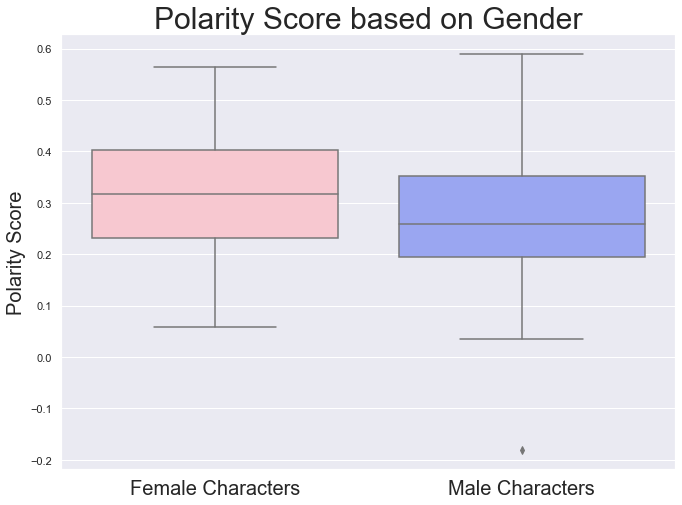

In [16]:
#Setting the color scheme
curr_pal = {0: "pink", 1: "#8C9CFF"}
#sns.set(rc={'figure.figsize':(11,8)})
#Sizing up the font of the x-axis
plt.rc('xtick',labelsize=20)
#Plotting the boxplot and adding all labels
sns.boxplot(data=char_stat, x="Gender", y="Polarity Score", palette=curr_pal)
plt.xlabel( "" , size = 15 )
plt.ylabel( "Polarity Score" , size = 20 )
plt.xticks([0, 1], ['Female Characters', 'Male Characters'])
plt.title( "Polarity Score based on Gender" , size = 30 )


Text(0.5, 1.0, 'Polarity Score based on Rarity')

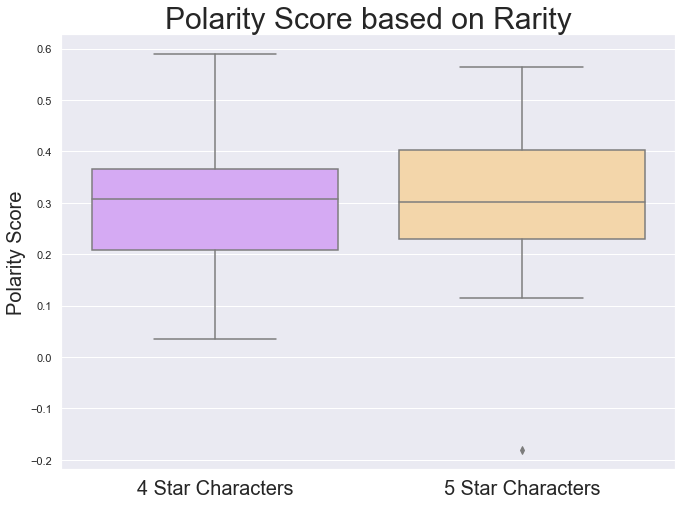

In [18]:
#Setting the color scheme
curr_pal = {5.0: "#FFD99E", 4.0: "#D79EFF"}
#Plotting the boxplot and adding all labels
sns.boxplot(data=char_stat, x="Rarity", y="Polarity Score", palette=curr_pal)
plt.xlabel( "" , size = 15 )
plt.ylabel( "Polarity Score" , size = 20)
plt.xticks([0, 1], ['4 Star Characters', '5 Star Characters'])
plt.title( "Polarity Score based on Rarity" , size = 30 )


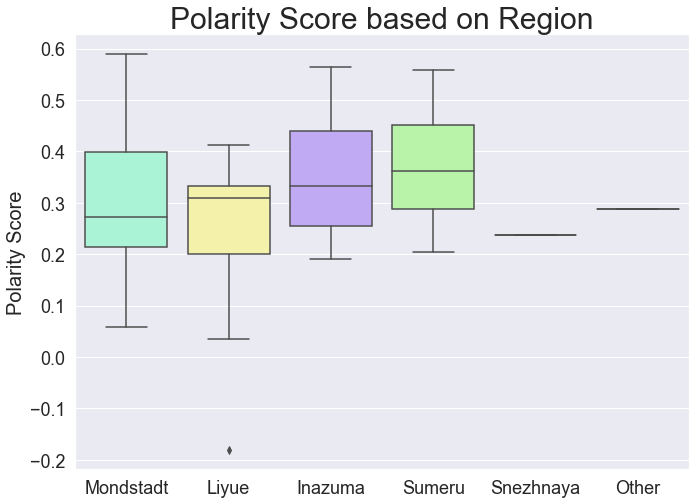

In [36]:
#Setting the color scheme
curr_pal = {0: "#9EFFDA", 1: "#FFFD9E", 2: "#BB9EFF", 3: "#B2FF9E", 
           4: "#B2FF9E", 5: "gray"}
#Plotting the boxplot and adding all labels
sns.boxplot(data=char_stat, x="Region", y="Polarity Score", palette=curr_pal)
plt.xlabel( "" , size = 15 )
plt.ylabel( "Polarity Score" , size = 20 )
plt.xticks([0, 1,2,3,4,5], ['Mondstadt', 'Liyue','Inazuma', 'Sumeru', 'Snezhnaya', 'Other'])
plt.title( "Polarity Score based on Region" , size = 30 )

plt.rc('xtick',labelsize=10)

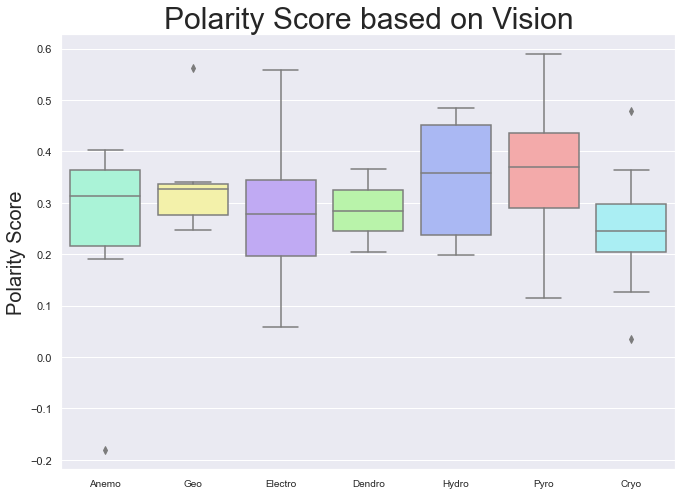

In [20]:
#Setting the color scheme
curr_pal = {0: "#9EFFDA", 1: "#FFFD9E", 2: "#BB9EFF", 3: "#B2FF9E", 
          4: "#9EB1FF", 5: "#FF9E9E", 6:"#9EF8FF"}
#Plotting the boxplot and adding all labels
sns.boxplot(data=char_stat, x="Vision", y="Polarity Score", palette=curr_pal)
plt.xlabel( "" , size = 15 )
plt.ylabel( "Polarity Score" , size = 20 )
plt.xticks([0,1,2,3,4,5,6], ['Anemo', 'Geo','Electro', 'Dendro', 'Hydro', 'Pyro', 'Cryo'])
plt.title( "Polarity Score based on Vision" , size = 30 )

plt.rc('xtick',labelsize=18)

Text(0.5, 1.0, 'Polarity Score based on Weapon')

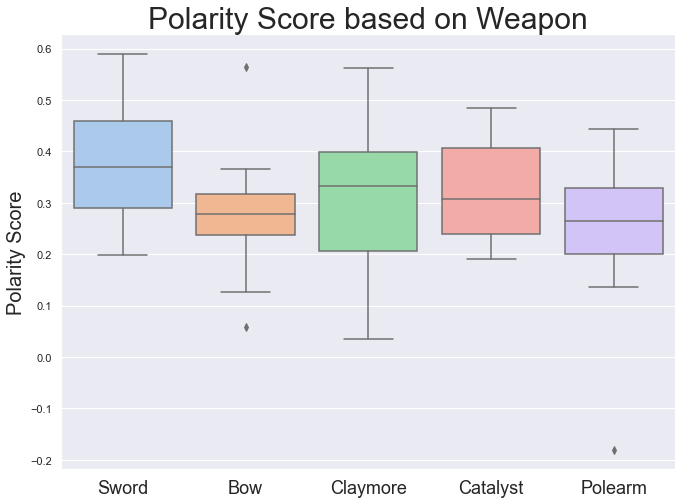

In [21]:
#Plotting the boxplot and adding all labels
sns.boxplot(data=char_stat, x="Weapon", y="Polarity Score", palette="pastel")
plt.xlabel( "" , size = 15 )
plt.ylabel( "Polarity Score" , size = 20 )
plt.xticks([0, 1,2,3,4], ['Sword', 'Bow', 'Claymore','Catalyst', 'Polearm'])
plt.title( "Polarity Score based on Weapon" , size = 30 )

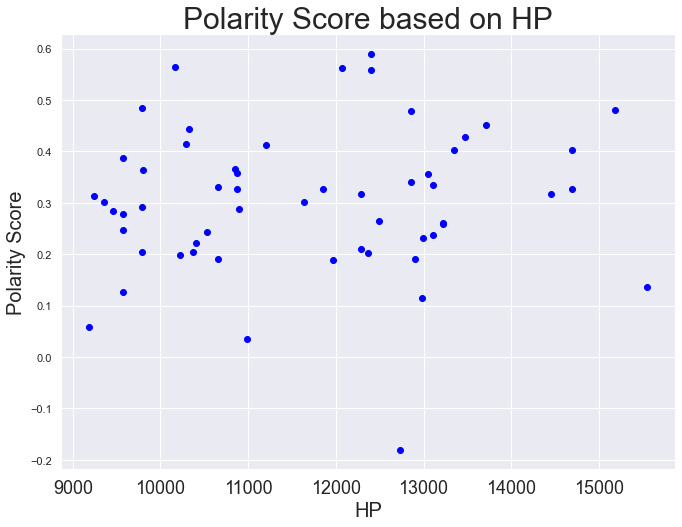

In [22]:
#Plotting the boxplot and adding all labels
plt.scatter(y=char_stat['Polarity Score'], x=char_stat['Base HP at level 90/90'], c="blue")
plt.xlabel( "HP" , size = 20 )
plt.ylabel( "Polarity Score" , size = 20 )
plt.title( "Polarity Score based on HP" , size = 30 )
plt.rc('xtick',labelsize=10)

Text(0.5, 1.0, 'Polarity Score based on Attack')

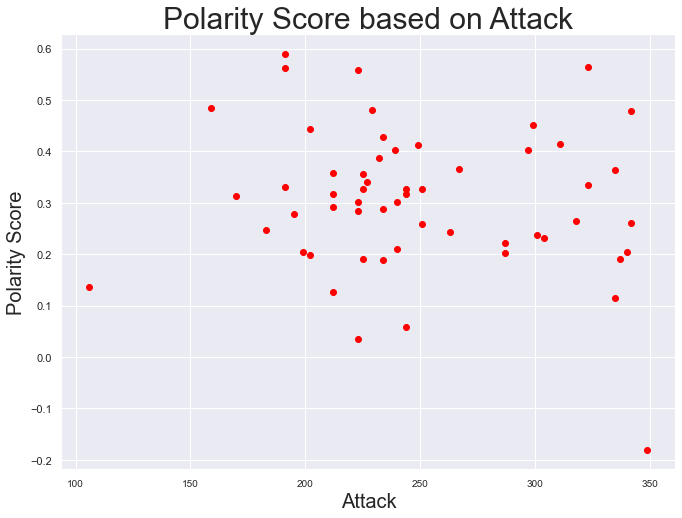

In [23]:
#Plotting the boxplot and adding all labels
plt.scatter(y=char_stat['Polarity Score'], x=char_stat['Base ATK at level 90/90'], c="red")
plt.xlabel( "Attack" , size = 20 )
plt.ylabel( "Polarity Score" , size = 20 )
plt.title( "Polarity Score based on Attack" , size = 30 )

Text(0.5, 1.0, 'Polarity Score based on Defense')

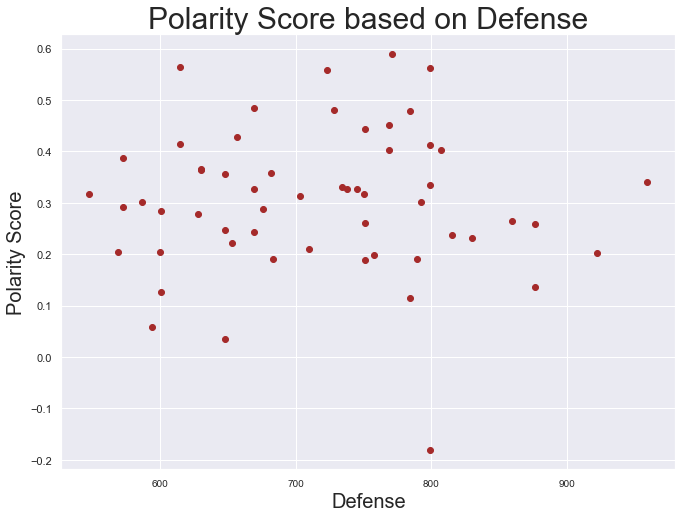

In [24]:
#Plotting the boxplot and adding all labels
plt.scatter(y=char_stat['Polarity Score'], x=char_stat['Base DEF at level 90/90'], c="brown")
plt.xlabel( "Defense" , size = 20 )
plt.ylabel( "Polarity Score" , size = 20 )
plt.title( "Polarity Score based on Defense" , size = 30 )

Text(0, 0.5, 'Polarity Score')

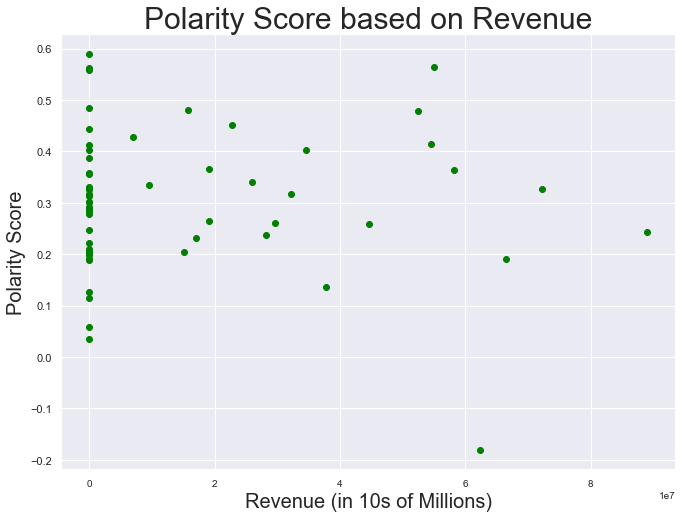

In [25]:
#Plotting the boxplot and adding all labels
x = char_stat['Revenue']
y = char_stat['Polarity Score']
plt.title( "Polarity Score based on Revenue" , size = 30 )
plt.scatter(x, y, c="green")
plt.xlabel( "Revenue (in 10s of Millions)" , size = 20 )
plt.ylabel( "Polarity Score" , size = 20 )


<h2>Exploratory data analysis</h2>

Now it's time to further analyze my data. I want to find any correlations between the polarity scores of voice lines and any other data I've collected. To do that, I'll calculate the correlation values between all of my data and display that in a seaborn heat map.

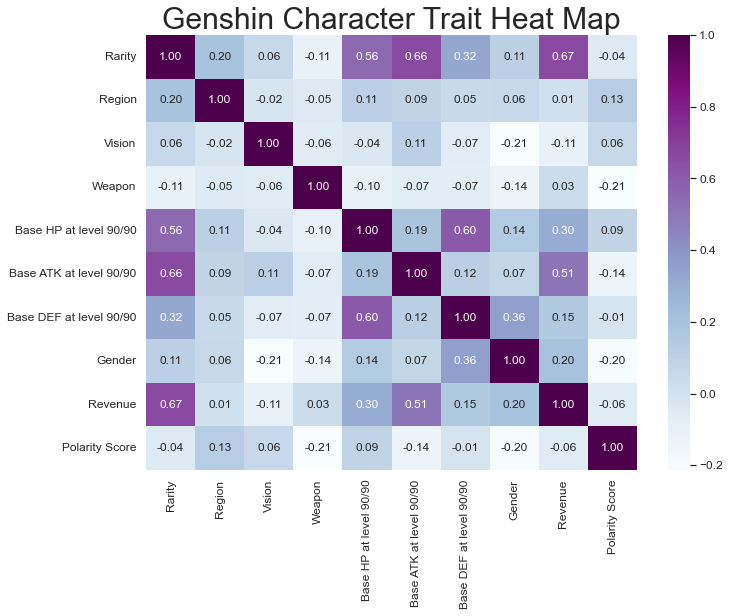

In [30]:
#Plotting the heat map and adding all labels
ax = sns.heatmap(char_stat.corr(), cmap="BuPu",annot=True, fmt='.2f')
plt.title("Genshin Character Trait Heat Map", size=30)
plt.rc('ytick',labelsize=10)
plt.rc('xtick',labelsize=10)
plt.show()


I'm also creating another heat map calculating the correlation between revenue and polarity. As mentioned before, some of the characters in the dataset don't have a recorded revenue, and I gave those characters revenues of 0. This results in the correlation calculation not being entirely representative of what it should be, as missing values were replace with 0. To account for this, I'll instead narrow down my analysis to only focus on characters that do have recorded revenues. 

I'll only show the revenue and polarity score correlations in this heat map since those are the only calculations that are relevant for us. 

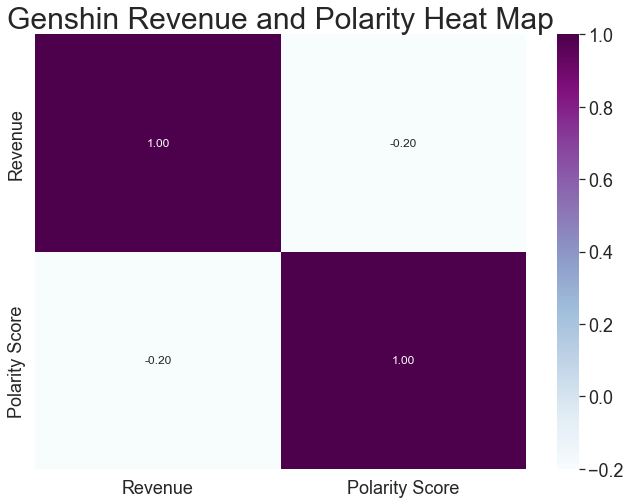

In [38]:
#Restricting plotted data to only characters with revenue
char_stat2 = char_stat[char_stat['Revenue'] != 0]
#Plotting the heat map and adding all labels
ax = sns.heatmap(char_stat2[['Revenue', 'Polarity Score']].corr(), cmap="BuPu",annot=True, fmt='.2f')
plt.title("Genshin Revenue and Polarity Heat Map", size=30)
plt.rc('ytick',labelsize=18)
plt.rc('xtick',labelsize=18)
plt.show()

Taking a look at our heat maps, we can see that the correlations between polarity and any other category typically range between -0.2 and 0.2. The highest correlation values (when you take the absolute value) related to polarity are Weapons with -0.21, Gender with -0.2, and Revenue with -0.2. Some other interesting things of note are that there are high correlation values between Defense and HP, Rarity and Attack, and Rarity and HP.  

<h2>Hypothesis Testing</h2>

My analysis focused on a couple of different factors, so I'll test out each one of those. Based on my analysis, above, I'll propose the following hypotheses.

<h3>Testing Polarity and Revenue Correlation</h3>

My first hypothesis statement is that for characters that bring in revenue, polarity is slightly inversely correlated with revenue. My null hypothesis would be that for characters that bring in revenue, polarity is in no way correlated with revenue. 

I want a hypothesis test that finds correlation between two pieces of data. I decide to use Spearman's Rank since each entry of my data is independent of each other and both polarity and revenue can be ranked. I'll use the spearmanr module from scipy for this, which you can learn more about <a href='https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html'>here</a>.

In [33]:
from scipy.stats import spearmanr
#Calculating p-value using Spearman's Rank
stat, p = spearmanr(char_stat2['Revenue'], char_stat2['Polarity Score'])
print('p = %.2F' % (p))

p = 0.43


For this test, to show correlation, the p-value would have to be less than or equal to 0.05. As we can see, Our calculated p value is 0.43, which is greater than 0.05, which means that the null hypothesis has not been rejected. Therefore our hypothesis has been proven false. 

<h3>Testing Polarity and Gender Correlation</h3>

Now let's figure out if there's any correlation between Gender and Polarity. My hypothesis will be that for all characters, their polarity is slightly inversely correlated with their gender. So my null hypothesis will be that for all characters, Polarity is in no way correlated with Gender.

This time we'll use the Pearson's Correlation Coefficient test, since Gender isn't a ranked piece of data, so Spearman's Rank would not be appropriate. We'll be using the pearsonr module form scipy, which you can learn more about <a href ="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html">here</a>.

In [34]:
from scipy.stats import pearsonr
#Calculating p-value using Pearson's Correlation Coefficient
stat, p = pearsonr(char_stat2['Gender'], char_stat2['Polarity Score'])
print('p = %.2F' % (p))

p = 0.30


For this test, to show correlation, the p-value would also have to be less than or equal to 0.05. But as we can see above, our p-value is 0.3, which is greater than that. This means that our null hypothesis has not been rejected and therefore our hypothesis is false. 

<h3>Testing Polarity and Weapon Correlation</h3>

For our last test, let's find out if there's any significant correlation between Polarity and Weapon. My null hypothesis will be that for all characters, the weapon and polarity of each character is slighty correlated. The null hypothesis is that the weapon and polarity of a character are not correlated at all. 

We'll use the Pearson's Correlation Coefficient again, since Weapon also isn't a ranked piece of data.

In [35]:
from scipy.stats import pearsonr
#Calculating p-value using Pearson's Correlation Coefficient
stat, p = pearsonr(char_stat2['Weapon'], char_stat2['Polarity Score'])
print('p = %.2F' % (p))

p = 0.01


As discussed, a p-value that would indicate correlation for this test would be less than or equal to 0.05. My p-value is 0.01, which is less than 0.05. This means that my null hypothesis has been rejected and my hypothesis is true. 

<h2>Communication of insights attained</h2>

By looking at our initial visualization, we saw that there were a few differences in a character's positive demeanor (the average polarity from their voice lines) when comparing against gender, weapon type, and vision, among other character traits. But when getting into the nitty-gritty and actually calculating correlation between polarity and all of these other aspects, most of them were independent from a character's voice line polarity. The only one that was dependent was weapon type, which while being an interesting insight, is just one out of what could've been many factoring components when it came to polarity. While this might seem disappointing from an analytical perspective, it's actually a good thing. Characters aren't restricted to only have certain types of personalites, like healers with more HP only being nice, or wielders of pyro only being less friendly. Ultimately this analysis shows characters in Genshin Impact are well rounded when it comes to personality.